In [72]:
import numpy as np
import pennylane as qml

In [5]:
n_qubits = 4
n_qlayers = 2
weights = np.random.rand(n_qlayers, n_qubits)
inputs = np.random.rand(n_qubits)

In [6]:
wires_forget = range(n_qubits)
@qml.qnode(qml.device('default.qubit', wires = n_qubits))
def circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=wires_forget)
    qml.templates.BasicEntanglerLayers(weights, wires=wires_forget)
    return [qml.expval(qml.PauliZ(wires=w)) for w in wires_forget]

(<Figure size 1400x500 with 1 Axes>, <Axes: >)

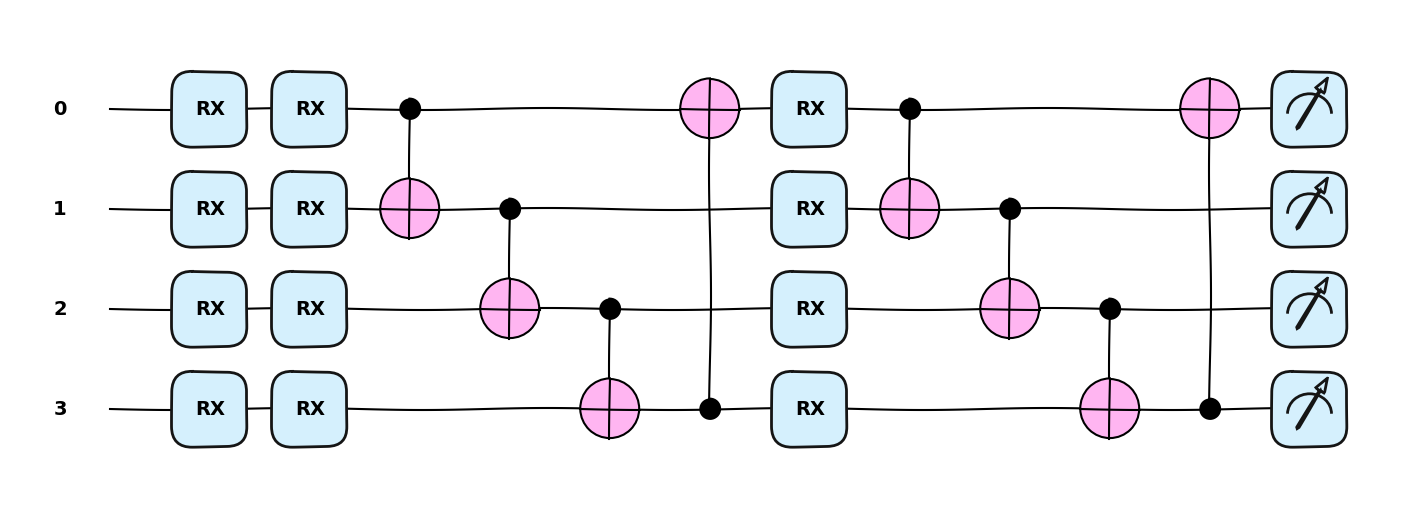

In [7]:
qml.draw_mpl(circuit, style="pennylane", expansion_strategy='device')(inputs, weights)

In [62]:
import torch
n_qubits = 4
n_qlayers = 2
weights = torch.rand(n_qlayers, n_qubits)
inputs = torch.tensor([[-0.4394, -1.4457, -0.9842,  3.0977],
        [-0.5673, -1.4949, -0.8720,  3.0366],
        [-0.4923, -1.2417, -0.7767, -2.7977],
        [-0.2441, -1.3607, -1.3348, -2.9805],
        [-0.0796, -0.9863, -1.1260, -2.3943],
        [ 0.5371, -1.3025, -2.3922, -2.9705],
        [ 0.6015, -1.5752, -2.8358,  2.8829],
        [ 0.4869, -1.5274, -2.5181,  2.9213],
        [ 0.4286, -1.5187, -2.4946,  2.9761],
        [ 0.3683, -1.6192, -2.4112,  2.7616],
        [ 0.4746, -1.5640, -2.5590,  2.8712],
        [ 0.3949, -1.5777, -2.4876,  2.8699],
        [ 0.5515, -1.0187, -2.1276, -2.4901],
        [ 0.8819, -1.3605, -3.0895, -3.0273],
        [ 0.9512, -1.4711,  2.9565,  3.0753],
        [ 0.9081, -1.5800,  2.9098,  2.8940]])
wires_forget = range(n_qubits)

print(inputs[0])

# @qml.qnode(qml.device('default.qubit', wires=64))
device = qml.device('qiskit.ibmq', wires=64, backend="simulator_mps", ibmqx_token="XXX")
def circuit(inputs, weights):
    num_slices = 16
    slice_size = 4
    num_qubits = 127

    # Loop through each slice to apply AngleEmbedding and variational_layer
    for slice_idx in range(num_slices):
        start_qubit = (slice_idx * slice_size) % num_qubits
        # Map numerical indices to custom wire labels
        wires_slice = range(start_qubit, start_qubit + slice_size)

        qml.templates.AngleEmbedding(inputs[start_qubit:start_qubit + slice_size], wires=wires_slice)
        qml.templates.BasicEntanglerLayers(weights, wires=wires_slice)

    # After encoding all slices, measure all used qubits at once
    all_expvals = [qml.expval(qml.PauliZ(wires=w)) for w in range(num_slices * slice_size)]

    return all_expvals

tensor([-0.4394, -1.4457, -0.9842,  3.0977])


In [66]:
qlayer = qml.QNode(circuit, device, interface="torch")
forget = qml.qnn.TorchLayer(qlayer, weight_shapes={"weights": (n_qlayers, n_qubits)})

In [67]:
b = torch.flatten(inputs)
b

tensor([-0.4394, -1.4457, -0.9842,  3.0977, -0.5673, -1.4949, -0.8720,  3.0366,
        -0.4923, -1.2417, -0.7767, -2.7977, -0.2441, -1.3607, -1.3348, -2.9805,
        -0.0796, -0.9863, -1.1260, -2.3943,  0.5371, -1.3025, -2.3922, -2.9705,
         0.6015, -1.5752, -2.8358,  2.8829,  0.4869, -1.5274, -2.5181,  2.9213,
         0.4286, -1.5187, -2.4946,  2.9761,  0.3683, -1.6192, -2.4112,  2.7616,
         0.4746, -1.5640, -2.5590,  2.8712,  0.3949, -1.5777, -2.4876,  2.8699,
         0.5515, -1.0187, -2.1276, -2.4901,  0.8819, -1.3605, -3.0895, -3.0273,
         0.9512, -1.4711,  2.9565,  3.0753,  0.9081, -1.5800,  2.9098,  2.8940])

In [68]:
output = forget(b)

In [71]:
output_1d = output.view(16, 4)
output_1d

tensor([[ 0.1289,  0.1055, -0.1875,  0.0664],
        [ 0.1133,  0.0605, -0.1953, -0.0371],
        [ 0.1719,  0.1309, -0.1016,  0.0820],
        [ 0.1992, -0.0176, -0.1523,  0.3887],
        [ 0.1191,  0.2051, -0.1152,  0.3457],
        [ 0.1992, -0.0234, -0.1777,  0.4473],
        [ 0.2090,  0.0371, -0.2168,  0.2539],
        [ 0.2051, -0.0352, -0.2266,  0.4297],
        [ 0.2344, -0.0605, -0.2109,  0.4707],
        [ 0.2422, -0.0352, -0.1582,  0.4785],
        [ 0.2383,  0.0000, -0.1660,  0.4668],
        [ 0.2344, -0.0488, -0.1543,  0.4844],
        [ 0.0645,  0.0742, -0.1113,  0.5391],
        [ 0.0996, -0.0742, -0.1660,  0.0742],
        [ 0.1582, -0.1094, -0.1777, -0.0625],
        [ 0.1465, -0.0078, -0.2539, -0.1445]], grad_fn=<ViewBackward0>)

(<Figure size 1400x6500 with 1 Axes>, <Axes: >)

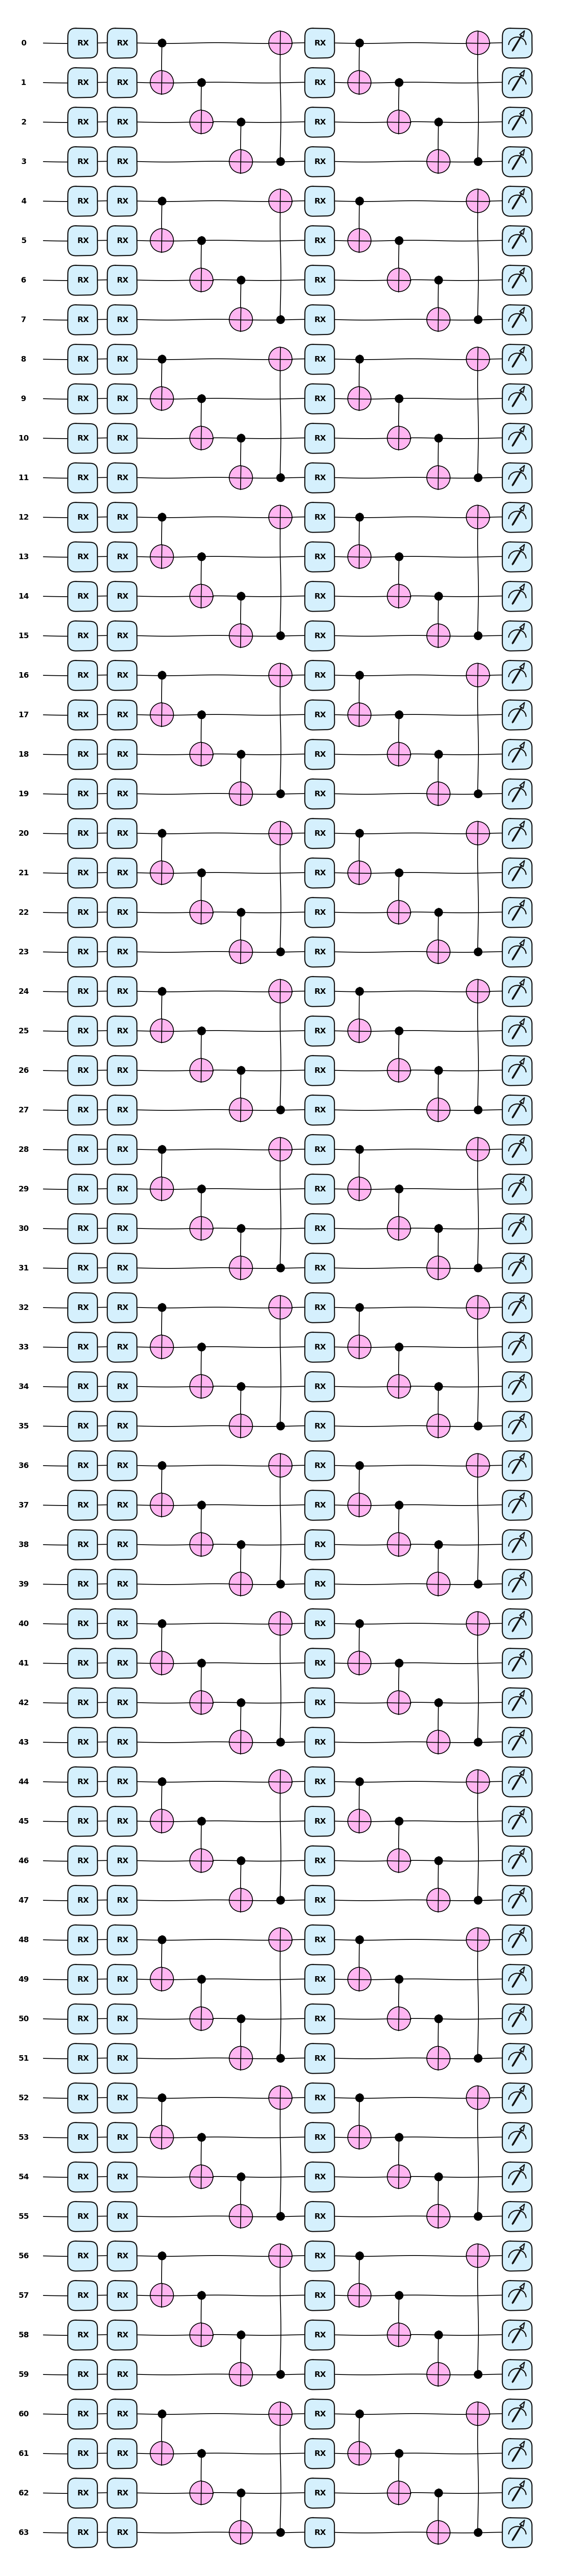

In [7]:
qml.draw_mpl(circuit, style="pennylane", expansion_strategy='device')(inputs, weights)